# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import VectorAssembler, StandardScaler

In [2]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from time import time

In [4]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Spark Sparkify App") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
user_log = spark.read.json("mini_sparkify_event_data.json")

user_log.createOrReplaceTempView("log_table")

In [6]:
spark.sql(
'''
SELECT
    *
FROM
    log_table
LIMIT 10
'''
).show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [7]:
spark.sql(
'''
describe
table
log_table
'''
).show()

+-------------+---------+-------+
|     col_name|data_type|comment|
+-------------+---------+-------+
|       artist|   string|   null|
|         auth|   string|   null|
|    firstName|   string|   null|
|       gender|   string|   null|
|itemInSession|   bigint|   null|
|     lastName|   string|   null|
|       length|   double|   null|
|        level|   string|   null|
|     location|   string|   null|
|       method|   string|   null|
|         page|   string|   null|
| registration|   bigint|   null|
|    sessionId|   bigint|   null|
|         song|   string|   null|
|       status|   bigint|   null|
|           ts|   bigint|   null|
|    userAgent|   string|   null|
|       userId|   string|   null|
+-------------+---------+-------+



Total number of users are 226

In [8]:
spark.sql(
'''
SELECT
    COUNT(DISTINCT userID)
FROM
    log_table
'''
).show()

+----------------------+
|count(DISTINCT userID)|
+----------------------+
|                   226|
+----------------------+



Out of 226 users, 52 have churned! 

In [9]:
spark.sql(
'''
SELECT
    COUNT(DISTINCT userID)
FROM
    log_table
WHERE
    page = 'Cancellation Confirmation'
'''
).show()

+----------------------+
|count(DISTINCT userID)|
+----------------------+
|                    52|
+----------------------+



Creating the churn column and writing it to 'user_data' table.

In [10]:
spark.sql(
'''
SELECT
    log_table.*,
    IF(churn_user_data.userID IS NOT NULL, 1, 0) AS churn
FROM
    log_table
LEFT JOIN
    (
    SELECT DISTINCT
        userID
    FROM
        log_table
    WHERE
        page = 'Cancellation Confirmation'
        ) AS churn_user_data
ON
    log_table.userID = churn_user_data.userID
'''
).createOrReplaceTempView('user_data')

Sanity Check: Numbers do seam reasonable

In [11]:
spark.sql(
'''
SELECT
    churn,
    COUNT(DISTINCT userID)
FROM
    user_data
GROUP BY
    1
'''
).show()

+-----+----------------------+
|churn|count(DISTINCT userID)|
+-----+----------------------+
|    1|                    52|
|    0|                   174|
+-----+----------------------+



In [12]:
churn_level_pd = spark.sql(
'''
SELECT
    churn,
    level,
    ct/SUM(ct) OVER (PARTITION by churn) as prop   
FROM
    (
    SELECT
        churn,
        level,
        COUNT(level) as ct
    FROM
        user_data
    GROUP BY
        1,2
    )
ORDER BY
    1, 2 DESC
'''
    
).toPandas()

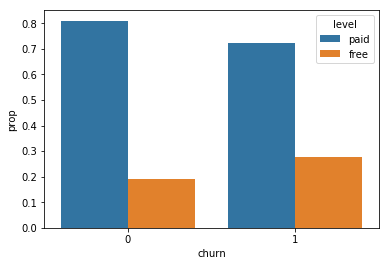

In [13]:
sns.barplot(x = "churn", y = "prop", hue = "level", data = churn_level_pd)

In [14]:
## Number of ms in a day
ms_day = 1000*60*60*24

In [15]:
avg_songs_pd = spark.sql(
'''
SELECT
    churn,
    userID,
    level,
    COUNT(song)*1000*60*60*24/(max(ts) - min(ts)) as songs_per_day
FROM
    user_data
GROUP BY
    1, 2, 3
'''
    
).toPandas()

Comparision on **average songs played per day**:
- Users who **churned listed to almost double the songs per day**(which is very counter intuitive)
- Both paid and free users listened to average more songs for churned users.

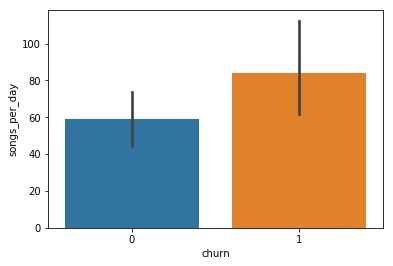

In [18]:
sns.barplot(x = "churn", y = "songs_per_day", data = avg_songs_pd)

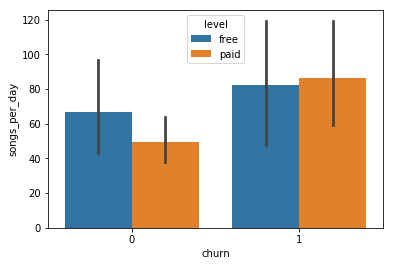

In [16]:
sns.barplot(x = "churn", y = "songs_per_day", hue = 'level', data = avg_songs_pd)

In [18]:
spark.sql(
'''
SELECT
    userId,
    (MAX(ts) - MIN(ts)) / (24 * 60 * 60 * 1000) AS days
FROM
    user_data
GROUP BY 
    1
'''
).createOrReplaceTempView('user_active_days')

In [19]:
spark.sql(
'''
SELECT
    churn,
    page,
    SUM(ct_page_per_day) as ct_page
FROM
    (
    SELECT
        page_data.userId,
        page_data.churn,
        page_data.page,
        page_data.ct_page/user_active_days.days as ct_page_per_day
    FROM
        (
            (
            SELECT
                userId,
                churn,
                page,
                count(*) as ct_page
            FROM
                user_data
            GROUP BY
                1, 2,3
            ) as page_data
            INNER JOIN
                user_active_days
            ON
                user_active_days.userId = page_data.userId
        )
    )
GROUP BY
    1, 2
'''


).createOrReplaceTempView('page_view_per_day')

## Identify 'interesting' pages affecting Churn  

In [21]:
spark.sql(
"""
SELECT
    COUNT(DISTINCT page)
FROM
    log_table
"""
).show()

+--------------------+
|count(DISTINCT page)|
+--------------------+
|                  22|
+--------------------+



In [20]:
spark.sql(
'''
SELECT
    *,
    prop_churned/prop_not_churned as ratio_churned
FROM
    (
    SELECT
        page,
        SUM(IF(churn = 1, prop, 0)) as prop_churned,
        SUM(IF(churn = 0, prop, 0)) as prop_not_churned
    FROM
        (
        SELECT
            churn,
            page,
            ct_page,
            ct_page/SUM(ct_page) OVER (PARTITION BY churn) as prop
        FROM
            page_view_per_day
        )
    GROUP BY
        1
    HAVING
        (prop_churned != 0
         AND prop_not_churned != 0
         AND prop_churned > .001) 
     )
WHERE
   prop_churned/prop_not_churned > 1.5
   OR
   prop_churned/prop_not_churned < .66
ORDER BY
    ratio_churned
'''
).show()

+-----------+--------------------+--------------------+------------------+
|       page|        prop_churned|    prop_not_churned|     ratio_churned|
+-----------+--------------------+--------------------+------------------+
|    Upgrade|0.001064780394279...|0.002175741662743413|0.4893873259462929|
|       Help|0.002514755114429223|0.004807227745889...|0.5231196122503916|
| Add Friend| 0.01849645013788031|0.012328938780059235|1.5002467339521854|
|Roll Advert| 0.06634414245506617|0.040053908404002594|1.6563712531093817|
|Thumbs Down| 0.01680986940756937|0.006520825210677021|2.5778745579693423|
+-----------+--------------------+--------------------+------------------+



So the churned out users
- Visited 'Upgrade' and 'Help' less
- 'Thumbs Down' a lot more (Which means they were disatisfied)
- 'Add friends' and 'Roll Advt' more

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [21]:
spark.sql(
'''
SELECT
    page_data.userId,
    page_data.churn,
    page_data.page,
    page_data.ct_page/user_active_days.days as ct_page_per_day
FROM
    (
    (
    SELECT
        userId,
        churn,
        page,
        count(*) as ct_page
    FROM
        user_data
    GROUP BY
        1, 2,3
    ) as page_data
    INNER JOIN
        user_active_days
    ON
        user_active_days.userId = page_data.userId
    )
''').createOrReplaceTempView('user_data_features')

In [22]:
spark.sql('''
SELECT
    userId,
    churn,
    SUM(IF(page = 'Upgrade', ct_page_per_day, 0)) AS ct_Upgrade,
    SUM(IF(page = 'Help', ct_page_per_day, 0)) AS ct_Help,
    SUM(IF(page = 'Add Friend', ct_page_per_day, 0)) AS ct_Add_Friend,
    SUM(IF(page = 'Roll Advert', ct_page_per_day, 0)) AS ct_Roll_Advert,
    SUM(IF(page = 'Thumbs Down', ct_page_per_day, 0)) AS ct_Thumbs_Down
FROM
    user_data_features
GROUP BY
    1, 2
''').createOrReplaceTempView('user_data_features')

In [23]:
user_data_df = spark.sql("""
SELECT
    user_data_features.*,
    avg_songs.songs_per_day
FROM
    user_data_features
LEFT JOIN
(
SELECT
    userID,
    COUNT(song)*1000*60*60*24/(max(ts) - min(ts)) as songs_per_day
FROM
    user_data
GROUP BY
    1) AS avg_songs
ON 
    avg_songs.userId = user_data_features.userId


""")

**user_data_df** will be used for ML Modeling

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [24]:
user_data_df.show(10)

+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+
|userId|churn|          ct_Upgrade|             ct_Help|       ct_Add_Friend|      ct_Roll_Advert|      ct_Thumbs_Down|     songs_per_day|
+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+
|100010|    0| 0.04523065277150301| 0.04523065277150301| 0.09046130554300602|  1.1759969720590784| 0.11307663192875753| 6.219214756081664|
|200002|    0| 0.04395913021976513| 0.04395913021976513| 0.08791826043953026| 0.15385695576917793| 0.13187739065929538| 8.506091697524552|
|   125|    1|                 0.0|                 0.0|                 0.0|   48.70349492671927|                 0.0|389.62795941375424|
|   124|    0|                 0.0| 0.38335285593247803|  1.2333961451740598| 0.06667006190130052|  0.6833681344883304| 67.98679562385121|
|    51|    1|             

In [25]:
columns_to_drop = ['userId', 'churn']

In [26]:
user_columns = user_data_df.columns
feature_columns = [x for x in user_columns if x not in columns_to_drop]

## Step1: Create Vector Assembler for Features


In [27]:
assembler = VectorAssembler(inputCols=feature_columns,outputCol="features")

In [28]:
output_assembler = assembler.transform(user_data_df)

In [29]:
output_assembler.show(10)

+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+
|userId|churn|          ct_Upgrade|             ct_Help|       ct_Add_Friend|      ct_Roll_Advert|      ct_Thumbs_Down|     songs_per_day|            features|
+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+
|100010|    0| 0.04523065277150301| 0.04523065277150301| 0.09046130554300602|  1.1759969720590784| 0.11307663192875753| 6.219214756081664|[0.04523065277150...|
|200002|    0| 0.04395913021976513| 0.04395913021976513| 0.08791826043953026| 0.15385695576917793| 0.13187739065929538| 8.506091697524552|[0.04395913021976...|
|   125|    1|                 0.0|                 0.0|                 0.0|   48.70349492671927|                 0.0|389.62795941375424|(6,[3,5],[48.7034...|
|   124|    0|                 0.0| 0.38

## Step 2: Split Data and Create Scaler and Evaluator 

In [30]:
train, test = output_assembler.randomSplit([0.8, 0.2], seed=87)

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

evaluator = MulticlassClassificationEvaluator(
    predictionCol='predicted_churn',
    labelCol='churn',
    metricName='f1'
)


## Step 3: Define ML Functions

Functions to 
- Train a Model
- Evaluate the accuracy and f1 on test data
- Explain features of a model


In [31]:
def train_model(train, scaler, evaluator, model_type = "lr"):
    """Train and Test the models.
    
    Args:
        train: Training dataset for training the model.
        scaler: Scaler used to normalize the data
        evaluator: for tuning hyperprameters
        model_type: Type of model. Permissible values
                    lr -> Logistic Regression
                    dt -> Decision Trees
                    rf -> Random Forest
    Returns:
        model_cls: Trained Classifier Model.
    """
    
    
    if model_type == "lr":
        cls = LogisticRegression(featuresCol="scaledFeatures", labelCol = "churn", 
                  predictionCol = "predicted_churn")
        param_grid_cls = ParamGridBuilder().addGrid(cls.maxIter, [50, 100]) \
            .addGrid(cls.threshold, [0.4, 0.5]) \
            .build()
    elif model_type == "dt":
        cls = DecisionTreeClassifier(featuresCol="scaledFeatures", labelCol = "churn", 
                  predictionCol = "predicted_churn")
        param_grid_cls = ParamGridBuilder().addGrid(cls.maxDepth, [3, 5, 10]) \
            .addGrid(cls.maxBins, [20, 32]) \
            .build()
    
    elif model_type == "rf":
        cls = RandomForestClassifier(
            featuresCol="scaledFeatures", labelCol = "churn", 
            predictionCol = "predicted_churn", featureSubsetStrategy="auto",
            impurity='gini')

        param_grid_cls = ParamGridBuilder().addGrid(cls.numTrees, [3, 5, 10]) \
            .addGrid(cls.maxDepth, [5, 10, 20]) \
            .build()

        
    else:
        return "Please enter a valid model"
    
    pipeline = Pipeline(stages = [scaler, cls])

    tvs = TrainValidationSplit(estimator=pipeline,
                               estimatorParamMaps=param_grid_cls,
                               evaluator=evaluator,
                               trainRatio=0.8)

    start = time()
    model_cls = tvs.fit(train)  ## trying crossvalidator
    end = time()
    print('The {} training process took {:.1f} mins'.format(
        model_type, (end - start)/60))
          
    return model_cls

In [32]:
def test_model(test, model_cls, evaluator):
    """Evaluates the model on the test data.
    
    Args:
        test: test dataset
        model_cls: Classifier model to be tested
        evaluator: Evaluator for calculating evaluation metrics
    """
    
    results_cls = model_cls.transform(test)
      
    print("F1 score: {:.2f}, Accuracy: {:.2f}".format(
        evaluator.evaluate(results_cls, {evaluator.metricName:"f1"}),
        evaluator.evaluate(results_cls, {evaluator.metricName:"accuracy"})
    ))

In [33]:
def explain_model(model_cls, model_type, feature_list = feature_columns):
    """Explain the model. 
    
    Args:
        model_cls: Classifier Model
        model_type: Type of model
        feature_list: Input feature list
    """

    bestPipeline = model_cls.bestModel
    model_explanation = {}
    
    if model_type == 'lr':
        for i in range(len(bestPipeline.stages[1].coefficients)):
            model_explanation[
                feature_columns[i]] = bestPipeline.stages[1].coefficients[i]*100
            
        print('Best parameters: maxIter:{}, Threshold:{} \n'.format(
            bestPipeline.stages[1].getOrDefault('maxIter'),
            bestPipeline.stages[1].getOrDefault('threshold')))
        

    elif model_type == 'rf':
        for i in range(len(bestPipeline.stages[1].featureImportances)):
            model_explanation[
                feature_columns[i]] = bestPipeline.stages[1].featureImportances[i]*100
            
        print('Best parameters: maxDepth:{}, numTrees:{} \n'.format(
            bestPipeline.stages[1].getOrDefault('maxDepth'),
            bestPipeline.stages[1].getOrDefault('numTrees')))
    
    elif model_type == 'dt':
        for i in range(len(bestPipeline.stages[1].featureImportances)):            
            model_explanation[
                feature_columns[i]] = bestPipeline.stages[1].featureImportances[i]*100
            
        print('Best parameters: maxDepth:{}, maxBins:{} \n'.format(
            bestPipeline.stages[1].getOrDefault('maxDepth'),
            bestPipeline.stages[1].getOrDefault('maxBins')))
        
    else:
        return print('Please provide correct model type')
    
    ## Sort the model_explanation dict by feature importance in descending order
    model_explanation_sorted = dict(
        sorted(
            model_explanation.items(),
            key =  lambda x: x[1],
            reverse=True)
    )
    
    fig_dims = (10,5)
    plt.figure(figsize = fig_dims)
    ## Plot feature importance
    ax = sns.barplot(
        x = list(model_explanation_sorted.keys()),
        y = list(model_explanation_sorted.values())
    )
    ax.set(xlabel = "Feature", ylabel = "Importance")
    print ('Explaining the importance of features for {}'.format(
        model_type))
    plt.show()

## Step 4: Run the training, testing and feature evaluation. 
The steps would be run for 
- Logistic Regression
- Decision Trees
- Random Forest

In [34]:
model_lr = train_model(train, scaler, evaluator, model_type = "lr")
test_model(test, model_lr, evaluator)

The lr training process took 5.2 mins
F1 score: 0.6449, Accuracy: 0.6585


In [35]:
model_dt = train_model(train, scaler, evaluator, model_type = "dt")
test_model(test, model_dt, evaluator)

The dt training process took 4.1 mins
F1 score: 0.7157, Accuracy: 0.7073


In [36]:
model_rf = train_model(train, scaler, evaluator, model_type = "rf")
test_model(test, model_rf, evaluator)

The rf training process took 6.8 mins
F1 score: 0.8478, Accuracy: 0.8537


Best parameters: maxIter:50, Threshold:0.4 

Explaining the importance of features for lr


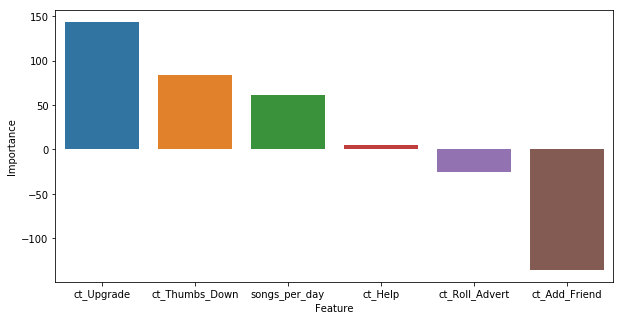

In [39]:
explain_model(model_lr, 'lr')

Best parameters: maxDepth:3, maxBins:20 

Explaining the importance of features for dt


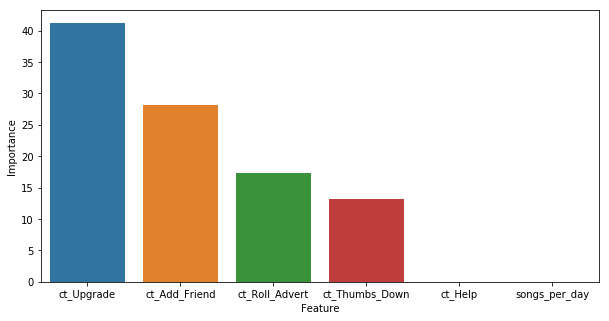

In [40]:
explain_model(model_dt,'dt')

Best parameters: maxDepth:5, numTrees:5 

Explaining the importance of features for rf


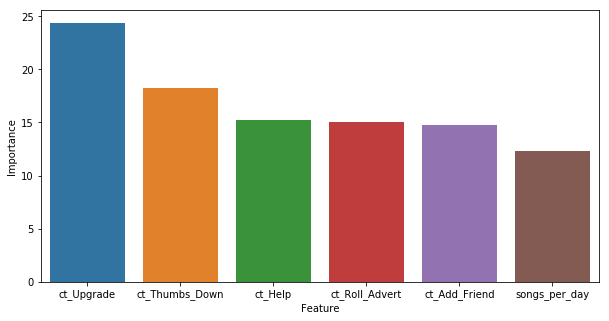

In [41]:
explain_model(model_rf, 'rf')

## Step 5: Conclusions

Discussion on 
- Which model was the best?
- Explanation of the best model

### Which Model is the best?

The Random Forrest has the best F1 and Accuracy Score

Random Forrest has the highest F1 score, followed by Decision Tree and Logistic Regression 

### Explanation of the Model
Top factors:
- Users who click on the **Upgrade More** more, churn more. 
- Same is true for user who click on **Thumbs Down** and **Help**
They are probably dissatisfied and trying to upgrade. 


Model can be further improved if we can use more data. 

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overvi
ew page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.